In [9]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import scipy
import scipy.signal
from torchvision import datasets

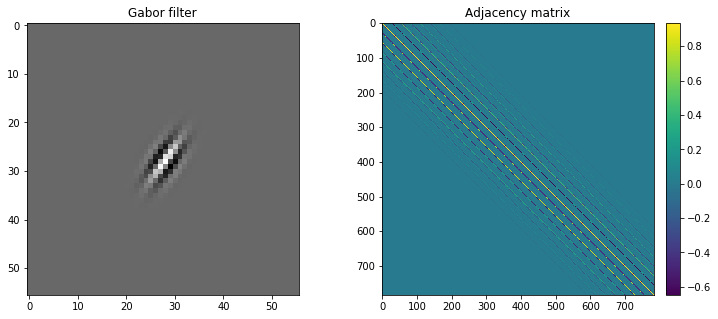

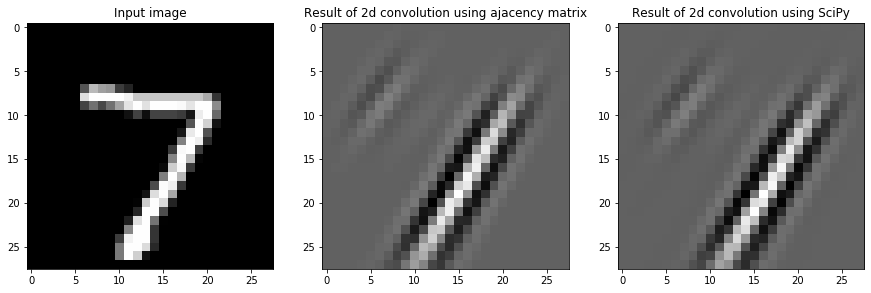

In [13]:
data = datasets.MNIST('./mnist', train=False, download=True)
images = (data.data.numpy() / 255.)
X = images[0].astype(np.float32)  # 28x28 MNIST image

# Create and plot the Gabor filter
N = X.shape[0]
x, y = np.meshgrid(np.arange(-float(N), N), np.arange(-float(N), N))
y = skimage.transform.rotate(y, 35)
x2 = skimage.transform.rotate(x, -35)
sigma = 0.75 * np.pi
lmbda = 1.5 * sigma
gamma = 1.3
gabor = np.exp(-(x**2 + gamma*y**2)/(2*sigma**2))*np.cos(2*np.pi*x2/lmbda)

# Create the adjacency matrix based on the Gabor filter without any zero-padding
A = np.zeros((N ** 2, N ** 2))
for i in range(N):
    for j in range(N):
        A[i*N + j, :] = gabor[N - i:N - i + N, N - j:N - j + N].flatten()
        
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Gabor filter')
plt.imshow(gabor, cmap='gray')
plt.subplot(122)
ax = plt.imshow(A)
plt.title('Adjacency matrix')
plt.colorbar(ax, fraction=0.046, pad=0.04)
plt.show()

# Perform 2d convolution as matrix multiplication
Y_adj = A.dot(X.reshape(-1, 1)).reshape(N, N)

# Plot the results and compare to the SciPy result
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Input image')
plt.imshow(X, cmap='gray')
plt.subplot(132)
plt.imshow(Y_adj, cmap='gray')
plt.title('Result of 2d convolution using ajacency matrix')
plt.subplot(133)
Y = scipy.signal.convolve2d(X, gabor, mode='same')
plt.imshow(Y, cmap='gray')
plt.title('Result of 2d convolution using SciPy')
plt.show()

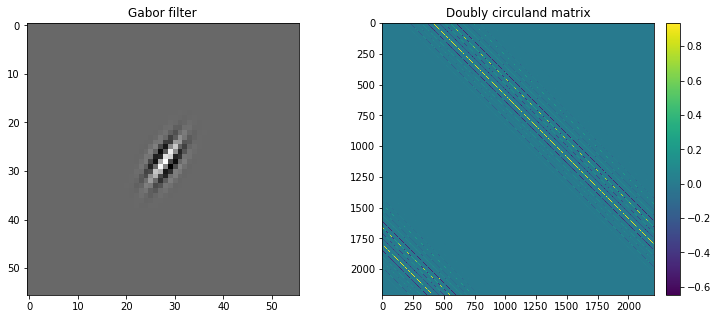

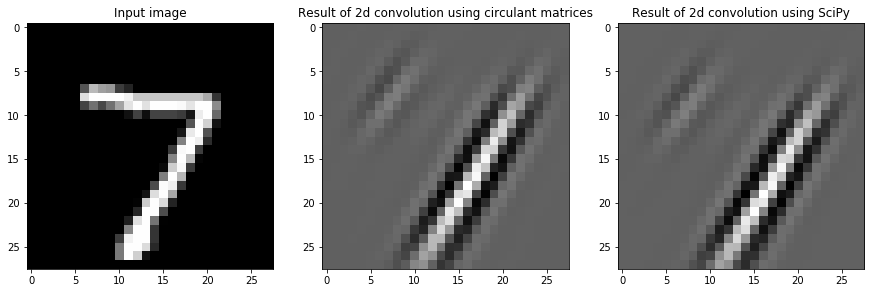

In [14]:
filter_width = 10  # effective width of a Gabor filter

# If you set 'pad' to 0, then A will be 784x784 and can be interpreted as an adjacency matrix
pad = filter_width * 2 - 1

# Create and plot the Gabor filter
N = X.shape[0]
x, y = np.meshgrid(np.arange(-float(N), N), np.arange(-float(N), N))
y = skimage.transform.rotate(y, 35)
x2 = skimage.transform.rotate(x, -35)
sigma = 0.75 * np.pi
lmbda = 1.5 * sigma
gamma = 1.3
gabor_filt = np.exp(-(x**2 + gamma*y**2)/(2*sigma**2))*np.cos(2*np.pi*x2/lmbda)

# Create and plot doubly circuland matrix for the defined Gabor filter
gabor = gabor_filt[filter_width:X.shape[0]+filter_width, X.shape[0]-filter_width:-filter_width]
gabor = np.pad(gabor, ((pad, 0), (0, pad)), 'constant')
A = [scipy.linalg.circulant(gabor[i, :]) for i in range(gabor.shape[0])]
blocks = []
for i in range(gabor.shape[0]):
    blocks.append([])
    for j in range(gabor.shape[0]):
        blocks[-1].append(A[i - j])    
A = np.block(blocks)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Gabor filter')
plt.imshow(gabor_filt, cmap='gray')
plt.subplot(122)
ax = plt.imshow(A)
plt.title('Doubly circuland matrix')
plt.colorbar(ax, fraction=0.046, pad=0.04)
plt.show()

X_pad = np.pad(X[:, :], ((int(np.ceil(pad / 2)), pad // 2), 
                         (int(np.ceil(pad / 2)), pad // 2)), 'constant')

# Perform 2d convolution as matrix multiplication
n = int(np.sqrt(A.shape[0]))
offset = np.max((0, (pad - filter_width * 2) // 2))
Y_circulant = A.dot(X_pad.reshape(-1, 1)).reshape(n, n)

# Cut the valid part of the convolution
Y_circulant = Y_circulant[offset: offset + X.shape[0], 
                          -X.shape[1] - offset: n - offset]

# Plot the results and compare to the SciPy result
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Input image')
plt.imshow(X, cmap='gray')
plt.subplot(132)
plt.imshow(Y_circulant, cmap='gray')
plt.title('Result of 2d convolution using circulant matrices')
plt.subplot(133)
Y = scipy.signal.convolve2d(X, gabor_filt, mode='same')
plt.imshow(Y, cmap='gray')
plt.title('Result of 2d convolution using SciPy')
plt.show()

In [17]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
from scipy.spatial.distance import cdist


class BorisGraphNet(nn.Module):
    def __init__(self, img_size=28, pred_edge=False):
        super(BorisGraphNet, self).__init__()
        self.pred_edge = pred_edge
        N = img_size ** 2
        self.fc = nn.Linear(N, 10, bias=False)
        if pred_edge:
            col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
            coord = np.stack((col, row), axis=2).reshape(-1, 2)
            coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
            coord = torch.from_numpy(coord).float()  # 784,2
            coord = torch.cat((coord.unsqueeze(0).repeat(N, 1,  1),
                                    coord.unsqueeze(1).repeat(1, N, 1)), dim=2)
            #coord = torch.abs(coord[:, :, [0, 1]] - coord[:, :, [2, 3]])
            self.pred_edge_fc = nn.Sequential(nn.Linear(4, 64),
                                              nn.ReLU(),
                                              nn.Linear(64, 1),
                                              nn.Tanh())
            self.register_buffer('coord', coord)
        else:
            # precompute adjacency matrix before training
            A = self.precompute_adjacency_images(img_size)
            self.register_buffer('A', A)


    @staticmethod
    def precompute_adjacency_images(img_size):
        col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
        coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
        dist = cdist(coord, coord)  
        sigma = 0.05 * np.pi
        
        # Below, I forgot to square dist to make it a Gaussian (not sure how important it can be for final results)
        A = np.exp(- dist / sigma ** 2)
        print('WARNING: try squaring the dist to make it a Gaussian')
            
        A[A < 0.01] = 0
        A = torch.from_numpy(A).float()

        # Normalization as per (Kipf & Welling, ICLR 2017)
        D = A.sum(1)  # nodes degree (N,)
        D_hat = (D + 1e-5) ** (-0.5)
        A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

        # Some additional trick I found to be useful
        A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

        print(A_hat[:10, :10])
        return A_hat

    def forward(self, x):
        B = x.size(0)
        if self.pred_edge:
            self.A = self.pred_edge_fc(self.coord).squeeze()

        avg_neighbor_features = (torch.bmm(self.A.unsqueeze(0).expand(B, -1, -1),
                                 x.view(B, -1, 1)).view(B, -1))
        return self.fc(avg_neighbor_features)

In [18]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

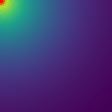

In [4]:
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import Image
import cv2  

img_size = 28
# Create/load some adjacency matrix A (for example, based on coordinates)
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # distances between all pairs of pixels
sigma = 0.2 * np.pi  # width of a Gaussian (can be a hyperparameter when training a model)

A = np.exp(- dist / sigma ** 2)  # adjacency matrix of spatial similarity
# above, dist should have been squared to make it a Gaussian (forgot to do that)

scale = 4
img_list = []
cmap = mpl.cm.get_cmap('viridis')
for i in np.arange(0, img_size, 4):  # for every row with step 4
    for j in np.arange(0, img_size, 4):  # for every col with step 4
        k = i*img_size + j
        img = A[k, :].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())
        img = cmap(img)
        img[i, j] = np.array([1., 0, 0, 0])  # add the red dot
        img = cv2.resize(img, (img_size*scale, img_size*scale))
        img_list.append((img * 255).astype(np.uint8))
imageio.mimsave('filter.gif', img_list, format='GIF', duration=0.2)
Image(filename="./filter.gif")